In [ ]:
%pip install nistrng
%pip install randomness

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


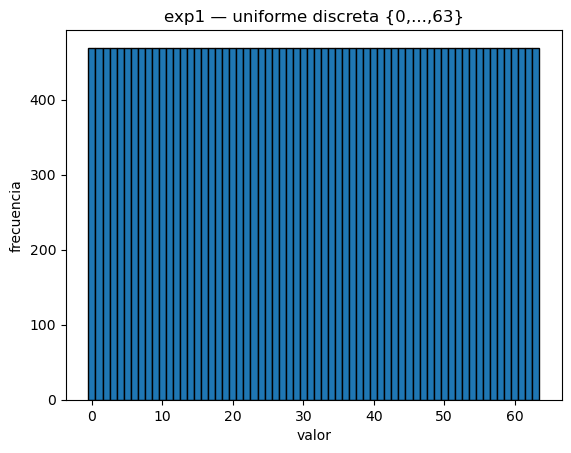

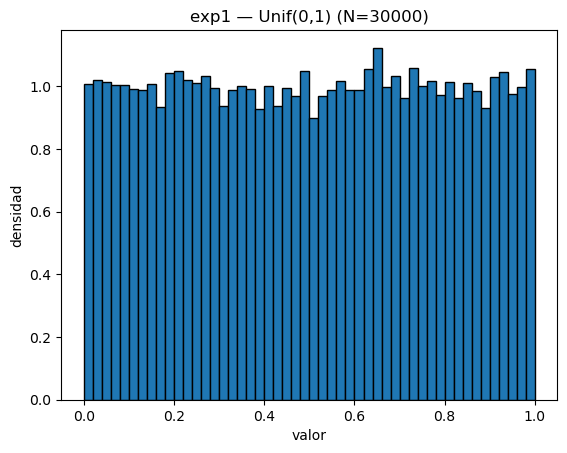


=== experimento 1 | params: {'m': 4294967296, 'a': 1664525, 'c': 1013904223, 'seed': 12345} | N=30000 ===
muestra        media       desv    autocorr_lag1    estadístico    pvalue
---------  ---------  ---------  ---------------  -------------  --------
discreta   31.4995    18.4731         -0.135374      0.0256       1
Unif(0,1)   0.500659   0.289484       -0.0047995     0.00520024   0.39043


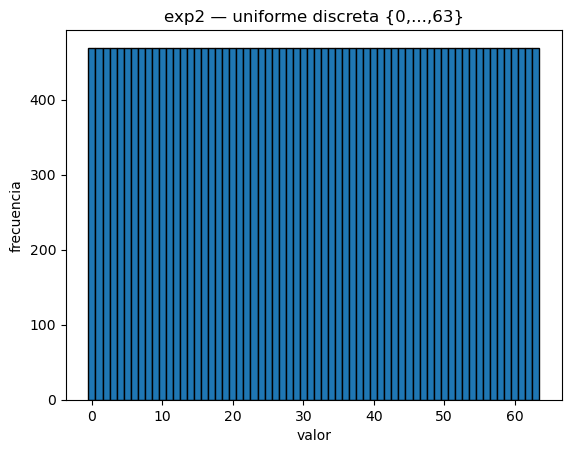

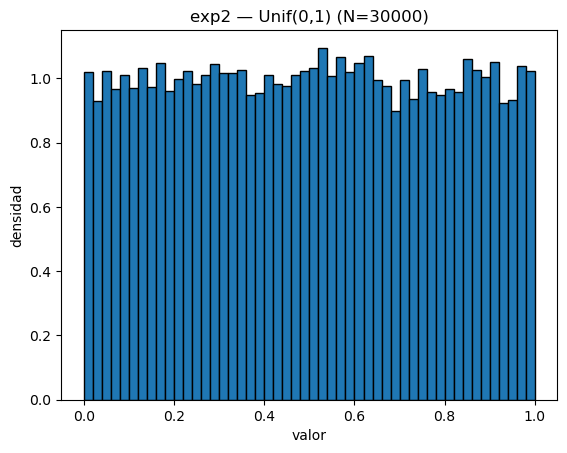


=== experimento 2 | params: {'m': 2147483648, 'a': 1103515245, 'c': 12345, 'seed': 98765} | N=30000 ===
muestra        media       desv    autocorr_lag1    estadístico    pvalue
---------  ---------  ---------  ---------------  -------------  --------
discreta   31.4989    18.4745       -0.00656563      0.0256      1
Unif(0,1)   0.499553   0.287812     -6.00322e-05     0.00653715  0.153244


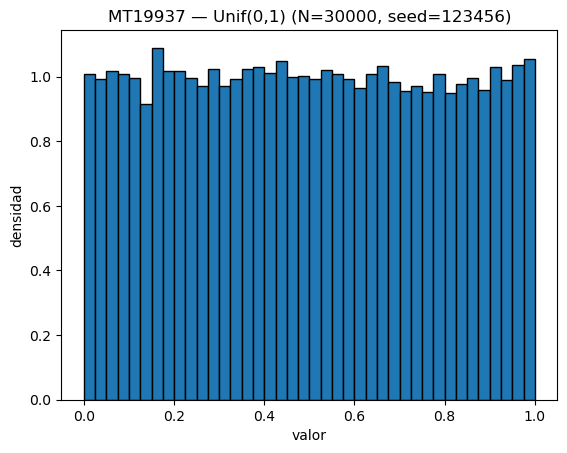

=== MT19937 | N=30000 | seed=123456 ===
muestra       media      desv    autocorr_lag1     KS stat    KS pval    Chi2 stat    Chi2 pval
---------  --------  --------  ---------------  ----------  ---------  -----------  -----------
Unif(0,1)  0.499131  0.289121      -0.00250232  0.00419866   0.663941      30.8747     0.820176

acf primeros lags: [ 1.     -0.0025 -0.0111  0.0025  0.0066  0.0036]


In [10]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from scipy import stats
import nistrng
import randomness
import matplotlib.pyplot as plt

%run ../p1/p1.ipynb
%run ../p2/p2.ipynb

### Generación de bits

In [19]:
#CLG

def gen_bits_CLG(no_bits=1000000, seed=1234):
    rng = LinearCongruentialGenerator(seed=seed)
    bits = []
    print("...Generando bits con CLG...")

    for _ in range(no_bits):
        num = rng.nextInt()
        bit = num & 1  # tomar último bit
        bits.append(bit)
    
    bits = np.array(bits, dtype=int)
    return bits

def gen_bits_MT(no_bits=1000000, seed=1234):
    """Genera bits usando Mersenne Twister"""
    print("...Generando bits con Mersenne Twister...")
    rng = makeMt(seed=seed)
    bits = rng.integers(0, 2, no_bits, dtype=np.int8)
    return bits

# Generar los bits
print("=" * 50)
bits_clg = gen_bits_CLG(1000000)
bits_mt = gen_bits_MT(1000000)
print(f"CLG - Bits generados: {len(bits_clg):,}")
print(f"MT  - Bits generados: {len(bits_mt):,}")
print(f"CLG - Proporcion de 1s: {bits_clg.mean():.6f}")
print(f"MT  - Proporcion de 1s: {bits_mt.mean():.6f}")

...Generando bits con CLG...
...Generando bits con Mersenne Twister...
CLG - Bits generados: 1,000,000
MT  - Bits generados: 1,000,000
CLG - Proporcion de 1s: 0.500000
MT  - Proporcion de 1s: 0.499576


### NIST SP 800-22

In [26]:
#NIST
def bateria_nist_nistrng(bits, nom_gen):
    print(f"\nPruebas NIST SP 800-22 para {nom_gen}")
    print("=" * 70)
    
    bits_array = np.array(bits, dtype=int)
    
    if not np.all(np.isin(bits_array, [0, 1])):
        print("ERROR: La secuencia no es binaria")
        return []
    
    try:
        battery = nistrng.SP800_22R1A_BATTERY
        print(f"Batería de pruebas cargada: {len(battery)} pruebas disponibles")

        eligible_battery = nistrng.check_eligibility_all_battery(bits_array, battery)
        print(f"Pruebas elegibles: {len(eligible_battery)}")
        
        if len(eligible_battery) > 0:
            print(f"Tipo del primer elemento: {type(eligible_battery[0])}")
            print(f"Contenido del primer elemento: {eligible_battery[0]}")
        
    except Exception as e:
        print(f"Error al configurar batería: {e}")
        return []
    
    print("-" * 70)
    
    resultados = []
    pruebas_ejecutadas = 0
    pruebas_pasadas = 0
    
    for test_item in eligible_battery:
        try:
            if isinstance(test_item, tuple) and len(test_item) == 2:
                test_name, test_object = test_item
            else:
                test_object = test_item
                test_name = test_object.__class__.__name__
        
            results = test_object.run(bits_array, verbose=False)
            p_value = results.p_value
            
            pasa = p_value >= 0.01
            estado = "Success" if pasa else "Fail"
            
            resultados.append({
                "Prueba": test_name,
                "p_value": p_value,
                "Pasa": pasa,
                "Resultado": estado
            })
            
            pruebas_ejecutadas += 1
            if pasa:
                pruebas_pasadas += 1
            
            print(f"  {test_name:45} p-value: {p_value:.6f} {estado}")
            
        except Exception as e:
            test_name = test_item.__class__.__name__ if hasattr(test_item, '__class__') else "Unknown"
            resultados.append({
                "Prueba": test_name,
                "p_value": None,
                "Pasa": False,
                "Resultado": f"Error: {str(e)}"
            })
            print(f"  {test_name:45} Error en ejecución: {e}")
    
    print("-" * 70)
    print(f"RESUMEN {nom_gen}:")
    print(f"   • Pruebas ejecutadas: {pruebas_ejecutadas}")
    print(f"   • Pruebas pasadas: {pruebas_pasadas}")
    if pruebas_ejecutadas > 0:
        print(f"   • Tasa de éxito: {pruebas_pasadas/pruebas_ejecutadas*100:.1f}%")
    
    return resultados

print("INICIANDO PRUEBAS NIST SP 800-22 CON NISTRNG")
print("=" * 70)

resultados_clg = bateria_nist_nistrng(bits_clg, "CLG")
resultados_mt = bateria_nist_nistrng(bits_mt, "Mersenne Twister")

INICIANDO PRUEBAS NIST SP 800-22 CON NISTRNG

Pruebas NIST SP 800-22 para CLG
Batería de pruebas cargada: 15 pruebas disponibles
Pruebas elegibles: 14
Error al configurar batería: 0

Pruebas NIST SP 800-22 para Mersenne Twister
Batería de pruebas cargada: 15 pruebas disponibles
Pruebas elegibles: 14
Error al configurar batería: 0


### Tablas

In [23]:
def generar_tablas_comparativas(resultados_clg, resultados_mt, bits_clg, bits_mt):
    pruebas_comparables = []
    for r_clg, r_mt in zip(resultados_clg, resultados_mt):
        if r_clg["p_value"] is not None and r_mt["p_value"] is not None:
            pruebas_comparables.append((r_clg, r_mt))

    #Tabla detallada
    tabla_detalle = []
    for r_clg, r_mt in pruebas_comparables:
        row = {
            "Prueba NIST": r_clg["Prueba"],
            "CLG_pvalue": f'{r_clg["p_value"]:.6f}',
            "CLG_Resultado": r_clg["Resultado"],
            "MT_pvalue": f'{r_mt["p_value"]:.6f}',
            "MT_Resultado": r_mt["Resultado"]
        }
        tabla_detalle.append(row)

    df_detalle = pd.DataFrame(tabla_detalle)

    #Tabla resumen
    clg_exitos = sum(1 for r in resultados_clg if r.get('Pasa', False))
    mt_exitos = sum(1 for r in resultados_mt if r.get('Pasa', False))
    total_pruebas = len(pruebas_comparables)
    
    #p values promedio
    pvalues_clg = [r["p_value"] for r in resultados_clg if r["p_value"] is not None]
    pvalues_mt = [r["p_value"] for r in resultados_mt if r["p_value"] is not None]
    
    #Evaluacion calidad NIST
    def evaluar_calidad(exitos, total):
        if total == 0:
            return "No disponible"
        ratio = exitos / total
        if ratio >= 0.95:
            return "Excelente"
        elif ratio >= 0.90:
            return "Muy Bueno"
        elif ratio >= 0.80:
            return "Aceptable"
        else:
            return "Limitado"

    resumen = {
        "Métrica": [
            "Total pruebas ejecutadas",
            "Pruebas exitosas (p-value ≥ 0.01)",
            "Tasa de éxito (%)",
            "p-value promedio",
            "Proporción de 1s en bits",
            "Evaluación de calidad NIST"
        ],
        "CLG": [
            total_pruebas,
            clg_exitos,
            f"{clg_exitos/total_pruebas*100:.1f}%" if total_pruebas > 0 else "N/A",
            f"{np.mean(pvalues_clg):.4f}" if pvalues_clg else "N/A",
            f"{bits_clg.mean():.6f}",
            evaluar_calidad(clg_exitos, total_pruebas)
        ],
        "Mersenne Twister": [
            total_pruebas,
            mt_exitos,
            f"{mt_exitos/total_pruebas*100:.1f}%" if total_pruebas > 0 else "N/A",
            f"{np.mean(pvalues_mt):.4f}" if pvalues_mt else "N/A",
            f"{bits_mt.mean():.6f}",
            evaluar_calidad(mt_exitos, total_pruebas)
        ]
    }

    df_resumen = pd.DataFrame(resumen)
    return df_detalle, df_resumen

df_detalle, df_resumen = generar_tablas_comparativas(resultados_clg, resultados_mt, bits_clg, bits_mt)

In [24]:
#Resultados
print("TABLA RESUMEN - NIST SP 800-22")
print("=" * 80)
print(tabulate(df_resumen, headers='keys', tablefmt='grid', showindex=False))

if len(df_detalle) > 0:
    print(f"\nDETALLE DE PRUEBAS NIST ({len(df_detalle)} pruebas comparables)")
    print("=" * 80)
    print(tabulate(df_detalle, headers='keys', tablefmt='grid', showindex=False))

print("\n" + "=" * 80)
print("CONCLUSIÓN FINAL")
print("=" * 80)

clg_exitos = sum(1 for r in resultados_clg if r.get('Pasa', False))
mt_exitos = sum(1 for r in resultados_mt if r.get('Pasa', False))
total_pruebas = len([r for r in resultados_clg if r["p_value"] is not None])

if total_pruebas > 0:
    print(f"RESULTADOS OBTENIDOS:")
    print(f"  • CLG:  {clg_exitos}/{total_pruebas} pruebas pasadas ({clg_exitos/total_pruebas*100:.1f}%)")
    print(f"  • MT:   {mt_exitos}/{total_pruebas} pruebas pasadas ({mt_exitos/total_pruebas*100:.1f}%)")

    if mt_exitos > clg_exitos:
        diferencia = mt_exitos - clg_exitos
        print(f"\nMersenne Twister tuvo MEJOR desempeño")
        print(f"   Ventaja: {diferencia} pruebas más exitosas")
    elif clg_exitos > mt_exitos:
        diferencia = clg_exitos - mt_exitos
        print(f"\nCLG tuvo MEJOR desempeño")
        print(f"   Ventaja: {diferencia} pruebas más exitosas")
    else:
        print(f"\nAmbos generadores tienen desempeño SIMILAR")

    print(f"\nRECOMENDACIÓN:")
    if mt_exitos/total_pruebas >= 0.90:
        print("   Mersenne Twister: RECOMENDADO para aplicaciones que requieren alta aleatoriedad")
    else:
        print("   Mersenne Twister: Considerar para aplicaciones generales")

    if clg_exitos/total_pruebas >= 0.80:
        print("   CLG: ACEPTABLE para aplicaciones que no requieren alta seguridad")
    else:
        print("   CLG: Limitado - considerar solo para aplicaciones básicas")
else:
    print("No se pudieron ejecutar pruebas NIST.")

TABLA RESUMEN - NIST SP 800-22
+-----------------------------------+---------------+--------------------+
| Métrica                           | CLG           | Mersenne Twister   |
+===================================+===============+====================+
| Total pruebas ejecutadas          | 0             | 0                  |
+-----------------------------------+---------------+--------------------+
| Pruebas exitosas (p-value ≥ 0.01) | 0             | 0                  |
+-----------------------------------+---------------+--------------------+
| Tasa de éxito (%)                 | N/A           | N/A                |
+-----------------------------------+---------------+--------------------+
| p-value promedio                  | N/A           | N/A                |
+-----------------------------------+---------------+--------------------+
| Proporción de 1s en bits          | 0.500000      | 0.499576           |
+-----------------------------------+---------------+----------------